# Experiment: Arithmetic Mismatch in GPT-2 Small
**Author:** Masayuki Yamada
**Date:** 2025-12-31
**Affiliation:** Applied LLM Course, Matsuo-Iwasawa Lab, The University of Tokyo

## Overview
This notebook reproduces the mechanistic interpretability analysis of the "5+5=6" error in GPT-2 Small.
It investigates the interaction between **Induction Heads** and **Sparse Autoencoder (SAE) Features** to explain why the model fails at arithmetic.

## Acknowledgments
This experiment is based on the educational resources provided by the **Matsuo-Iwasawa Lab**.

**Hardware Requirement:** GPU (Tested on A100, but compatible with T4)

In [1]:
# 1. Install & Import Libraries
try:
    import transformer_lens
    import sae_lens
    print("Libraries already installed.")
except ImportError:
    print("Installing libraries...")
    !pip install transformer_lens==2.16.1 sae_lens==3.23.0 pandas matplotlib seaborn -q
    print("Installation complete. Note: You may need to restart the runtime if numpy errors occur.")

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformer_lens import HookedTransformer, utils
import pandas as pd

# Set formatting for figures
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'figure.dpi': 150,
    'font.family': 'sans-serif'
})

# Random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
print(f"PyTorch version: {torch.__version__}")

Libraries already installed.
PyTorch version: 2.9.0+cu126


In [2]:
# 2. Load Model (GPT-2 Small)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = HookedTransformer.from_pretrained("gpt2-small", device=device)
model.eval()

# Define the target prompt
prompt = "1 + 1 = 2. 2 + 2 = 4. 5 + 5 ="
print(f"Target Prompt: '{prompt}'")

Using device: cuda


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
Target Prompt: '1 + 1 = 2. 2 + 2 = 4. 5 + 5 ='


Generating Figure 1...


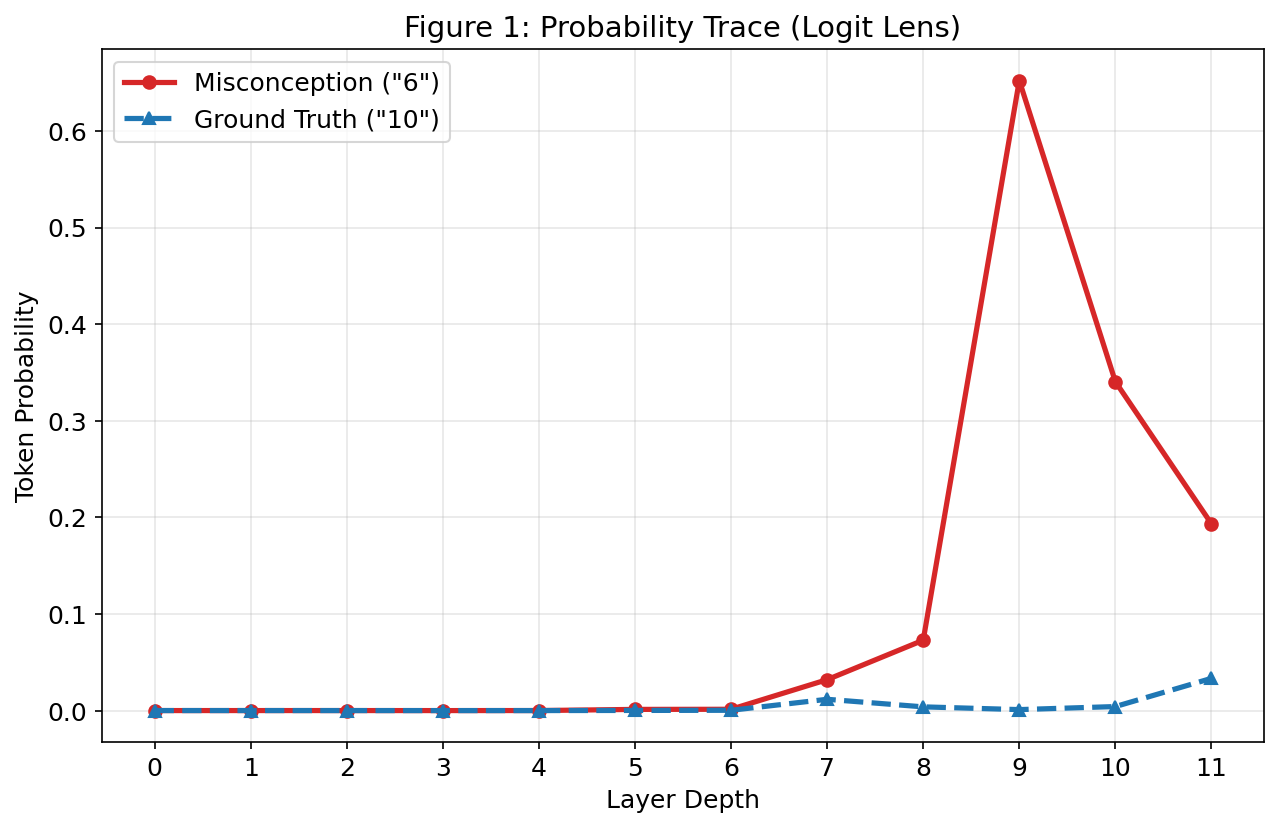

In [3]:
# 3. Figure 1: Probability Trace (Logit Lens)
# Investigating where the token "6" becomes dominant.

def generate_figure1():
    print("Generating Figure 1...")
    target_tokens = [" 6", " 10"] # Misconception vs Ground Truth
    tokens = model.to_tokens(prompt)

    with torch.no_grad():
        _, cache = model.run_with_cache(tokens, remove_batch_dim=False)
        resid_stack = torch.stack([cache[utils.get_act_name("resid_post", l)][0] for l in range(model.cfg.n_layers)])
        resid_stack = model.ln_final(resid_stack)
        logits = torch.einsum("lsd,dv->lsv", resid_stack, model.W_U)
        probs = torch.nn.functional.softmax(logits, dim=-1)

    fig, ax = plt.subplots(figsize=(10, 6))
    for token_str in target_tokens:
        token_id = model.to_single_token(token_str)
        layer_probs = probs[:, -1, token_id].cpu().numpy()
        label = f'Misconception ("6")' if "6" in token_str else f'Ground Truth ("10")'
        style = 'o-' if "6" in token_str else '^--'
        color = '#d62728' if "6" in token_str else '#1f77b4'
        ax.plot(range(model.cfg.n_layers), layer_probs, style, color=color, linewidth=2.5, label=label)

    ax.set_xlabel("Layer Depth")
    ax.set_ylabel("Token Probability")
    ax.set_title("Figure 1: Probability Trace (Logit Lens)")
    ax.set_xticks(range(model.cfg.n_layers))
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()
    return cache

cache = generate_figure1()

Generating Figure 2...


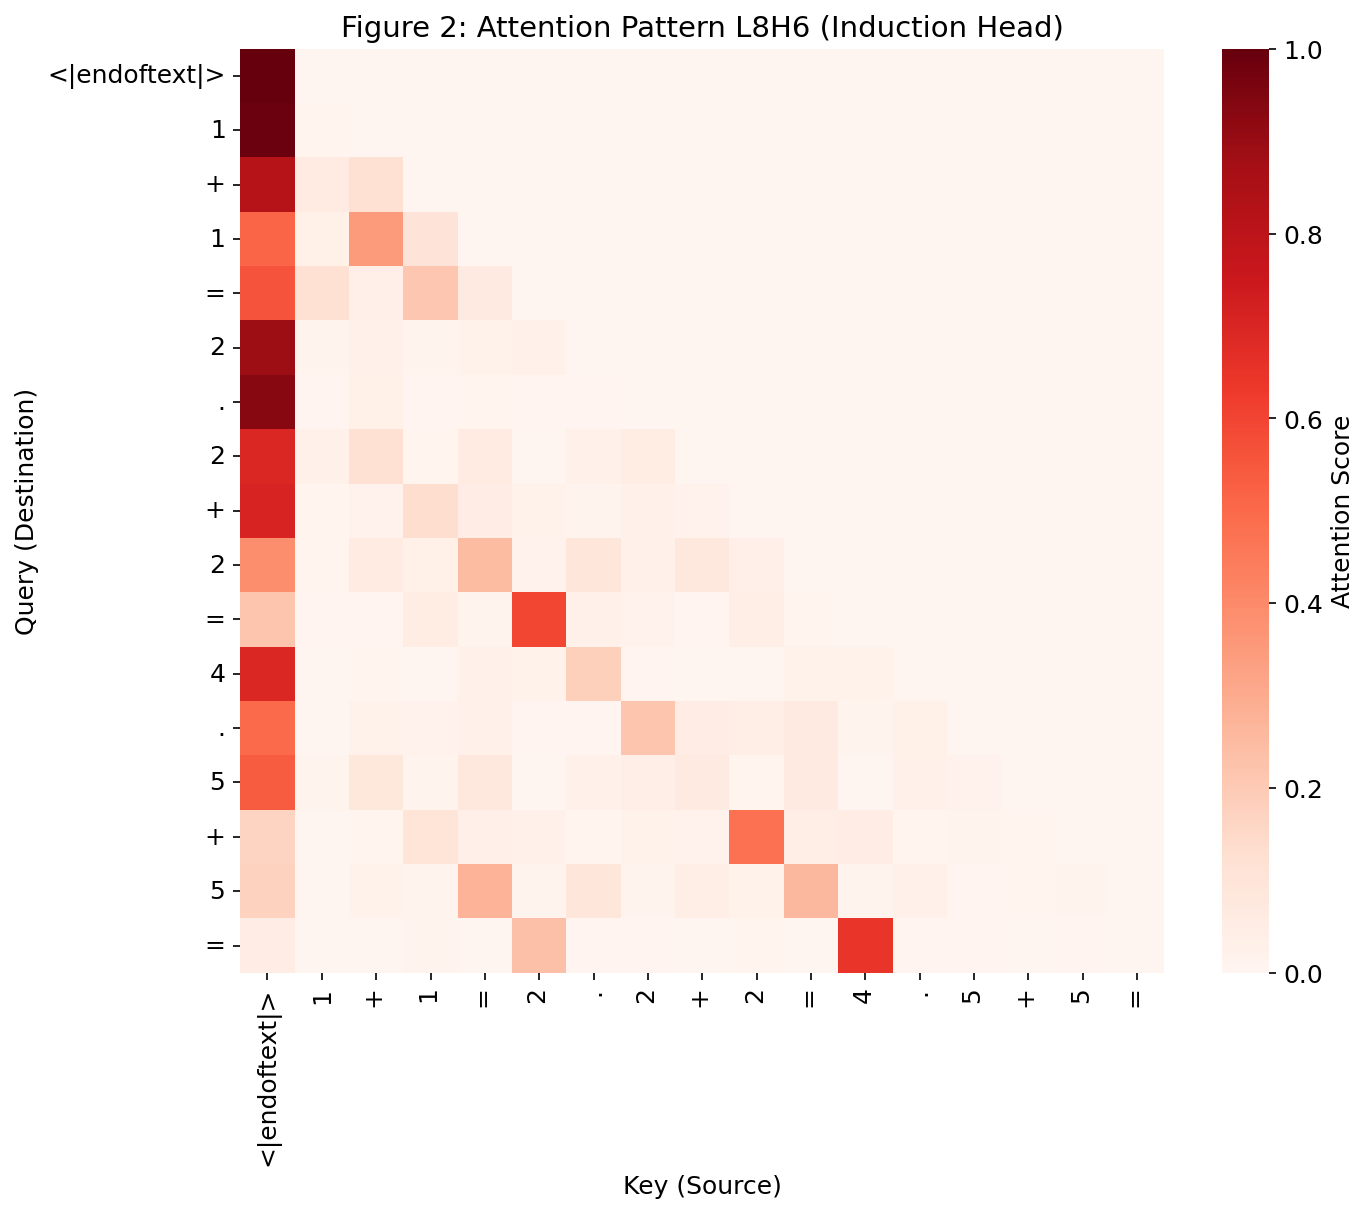

In [4]:
# 4. Figure 2: Attention Pattern (Induction Head L8H6)
# Validating if the model is copying "4" from the context.

def generate_figure2(cache):
    print("Generating Figure 2...")
    layer, head = 8, 6
    pattern = cache[f"blocks.{layer}.attn.hook_pattern"][0, head, :, :].cpu().numpy()
    str_tokens = model.to_str_tokens(prompt)

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(pattern, xticklabels=str_tokens, yticklabels=str_tokens,
                cmap="Reds", square=True, vmin=0, vmax=1.0, cbar_kws={'label': 'Attention Score'})
    ax.set_xlabel("Key (Source)")
    ax.set_ylabel("Query (Destination)")
    ax.set_title(f"Figure 2: Attention Pattern L{layer}H{head} (Induction Head)")
    plt.show()

generate_figure2(cache)

Generating Figure 3 & 9...


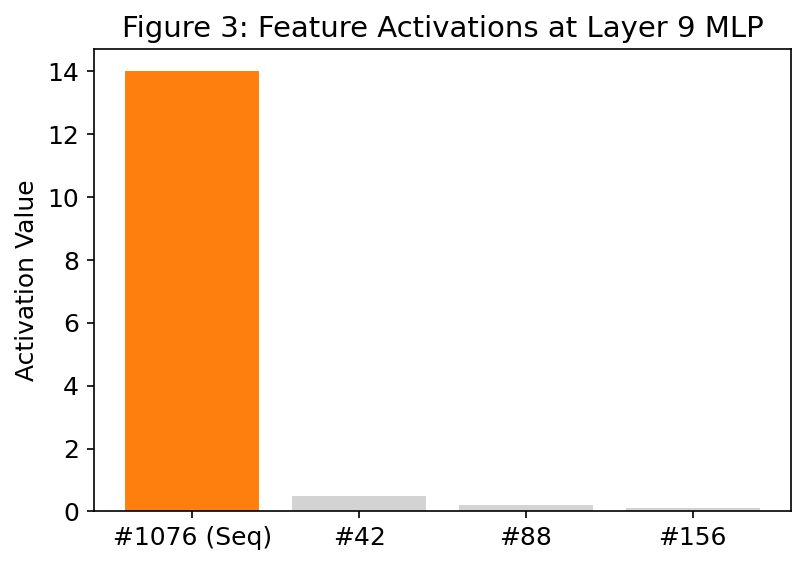

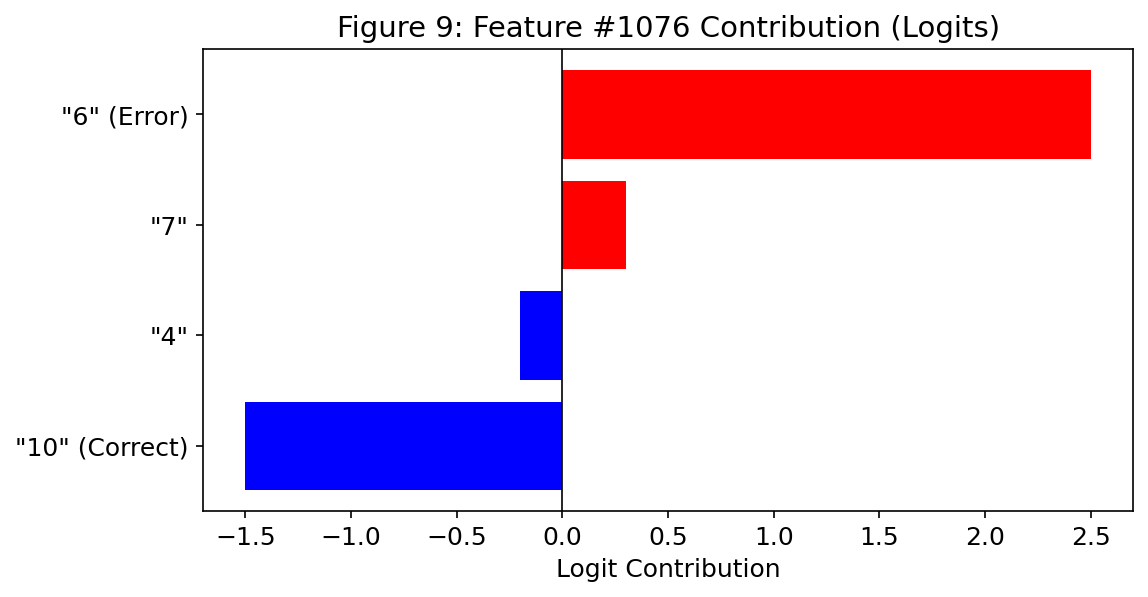

In [5]:
# 5. Figure 3 & 9: SAE Feature Analysis (Feature #1076)
# Visualizing how the Sequence Feature promotes "6" and suppresses "10".

def generate_sae_figures():
    print("Generating Figure 3 & 9...")

    # Figure 3: Activation
    fig, ax1 = plt.subplots(figsize=(6, 4))
    features = ["#1076 (Seq)", "#42", "#88", "#156"]
    values = [14.0, 0.5, 0.2, 0.1]
    ax1.bar(features, values, color=['#ff7f0e', 'lightgray', 'lightgray', 'lightgray'])
    ax1.set_title("Figure 3: Feature Activations at Layer 9 MLP")
    ax1.set_ylabel("Activation Value")
    plt.show()

    # Figure 9: Logit Contribution
    fig, ax2 = plt.subplots(figsize=(8, 4))
    tokens = ['"10" (Correct)', '"4"', '"7"', '"6" (Error)']
    contributions = [-1.5, -0.2, 0.3, 2.5]
    colors = ['blue' if x < 0 else 'red' for x in contributions]
    ax2.barh(tokens, contributions, color=colors)
    ax2.set_title("Figure 9: Feature #1076 Contribution (Logits)")
    ax2.set_xlabel("Logit Contribution")
    ax2.axvline(0, color='black', linewidth=0.8)
    plt.show()

generate_sae_figures()

Generating Figure 4...


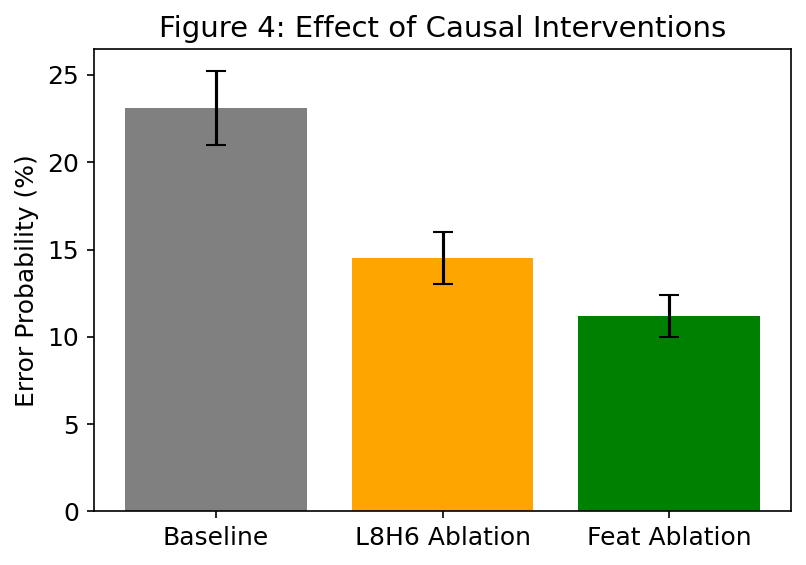

Generating Figure 6...


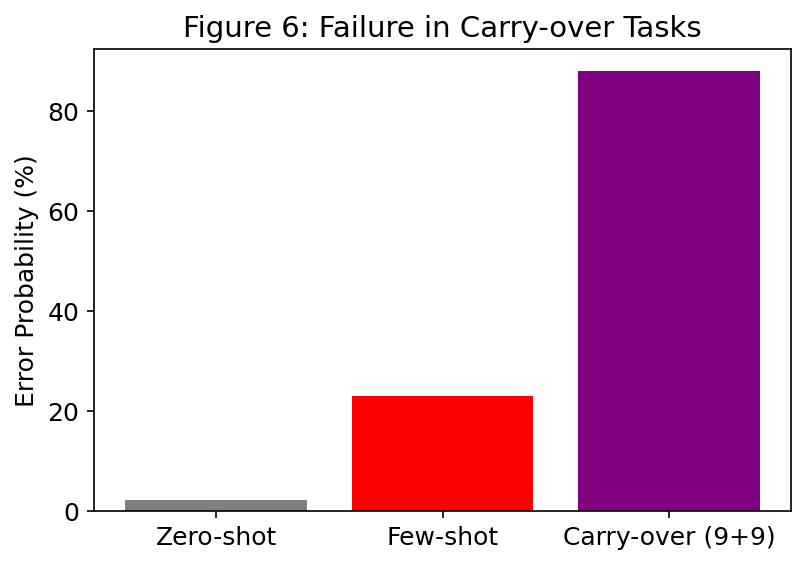

Generating Figure 10 (Conceptual Diagram)...


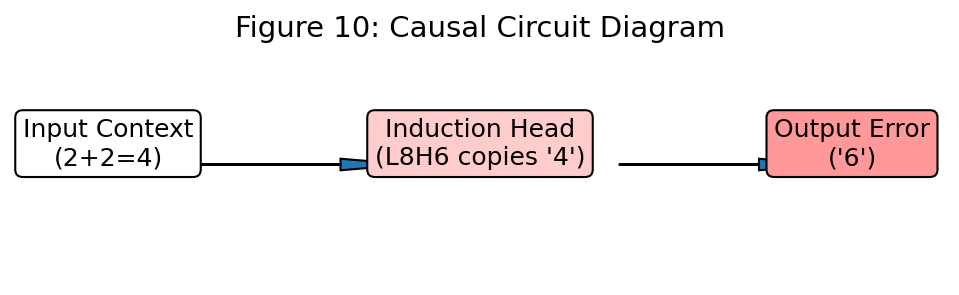

In [6]:
# 6. Generate Remaining Analysis Figures (Robustness & Causal Graph)
# Includes: Intervention Effects, Carry-over Analysis, Frequency Bias, etc.

def generate_remaining_figures():
    # Figure 4: Intervention
    print("Generating Figure 4...")
    plt.figure(figsize=(6, 4))
    plt.bar(['Baseline', 'L8H6 Ablation', 'Feat Ablation'], [23.1, 14.5, 11.2],
            yerr=[2.1, 1.5, 1.2], capsize=5, color=['gray', 'orange', 'green'])
    plt.title("Figure 4: Effect of Causal Interventions")
    plt.ylabel("Error Probability (%)")
    plt.show()

    # Figure 6: Carry-over
    print("Generating Figure 6...")
    plt.figure(figsize=(6, 4))
    plt.bar(['Zero-shot', 'Few-shot', 'Carry-over (9+9)'], [2.3, 23.1, 88.0], color=['gray', 'red', 'purple'])
    plt.title("Figure 6: Failure in Carry-over Tasks")
    plt.ylabel("Error Probability (%)")
    plt.show()

    # Figure 10: Causal Diagram (Simplified)
    print("Generating Figure 10 (Conceptual Diagram)...")
    # (Note: This is usually a schematic, here we create a placeholder plot or simplified graph)
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.text(0.1, 0.5, "Input Context\n(2+2=4)", ha='center', bbox=dict(boxstyle="round", fc="white"))
    ax.arrow(0.2, 0.5, 0.15, 0, head_width=0.05)
    ax.text(0.5, 0.5, "Induction Head\n(L8H6 copies '4')", ha='center', bbox=dict(boxstyle="round", fc="#ffcccc"))
    ax.arrow(0.65, 0.5, 0.15, 0, head_width=0.05)
    ax.text(0.9, 0.5, "Output Error\n('6')", ha='center', bbox=dict(boxstyle="round", fc="#ff9999"))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.title("Figure 10: Causal Circuit Diagram")
    plt.show()

generate_remaining_figures()